In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


1. # Import dataset and analysis

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Preprocessing

In [6]:
df_train = train_data.copy()
X_test = test_data.copy()

In [7]:
#drop usless columns
# Name is usless
# Cabin has to many Null
columns_to_drop = ['Name', 'Ticket', 'Cabin']
def drop_usless_columns(df):
    for column in columns_to_drop:
        df = df.drop(column, axis = 1)
    return df

In [8]:
#encoding Sex and Embarked
#male = 1
#female = 0
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
ohe = OneHotEncoder(sparse_output = False)
def encoding_columns(df):
    
    df['Sex_encoded'] = label_encoder.fit_transform(df['Sex'])
    df = df.drop('Sex', axis = 1)
    
    embarked_encoded = ohe.fit_transform(df[['Embarked']])
    df_encoded = pd.DataFrame(embarked_encoded, columns = ohe.get_feature_names_out(['Embarked']))
    df = pd.concat([df,df_encoded], axis = 1)
    df = df.drop('Embarked', axis = 1)
    
    return df

In [9]:
def fill_nan_with_mean(df):
    """
    Replace NaN values in a DataFrame with the mean value of the respective feature (column).

    Parameters:
    df (pandas.DataFrame): The input DataFrame with NaN values.

    Returns:
    pandas.DataFrame: A new DataFrame with NaN values replaced by feature-wise means.
    """
   # Identify columns with data types 'int64' and 'float64'
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

    # Calculate the mean for each numeric feature, ignoring NaN values
    feature_means = df[numeric_columns].mean(skipna=True)
    # Replace NaN values with the corresponding feature mean
    df_filled = df.fillna(feature_means)

    return df_filled

In [10]:
def create_ticket_frequency_feature(df):
    """
    Create a 'TicketFrequency' feature that counts how many times each ticket number appears in the dataset.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the 'Ticket' column.

    Returns:
    pandas.DataFrame: The DataFrame with the 'TicketFrequency' feature added.
    """
    # Count the frequency of each ticket number and create a new DataFrame
    ticket_counts = df['Ticket'].value_counts().reset_index()
    ticket_counts.columns = ['Ticket', 'TicketFrequency']

    # Merge the new DataFrame with the original DataFrame based on the 'Ticket' column
    df = pd.merge(df, ticket_counts, on='Ticket', how='left')

    return df

# Example usage:
# Assuming 'df_train' is your DataFrame containing the 'Ticket' column

In [11]:
df_train = create_ticket_frequency_feature(df_train)
X_test = create_ticket_frequency_feature(X_test)

In [12]:
df_train = encoding_columns(df_train)
df_train = drop_usless_columns(df_train)
df_train = df_train.drop('Embarked_nan', axis = 1)
X_test = encoding_columns(X_test)
X_test = drop_usless_columns(X_test)
df_train

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,TicketFrequency,Sex_encoded,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,1,1,0.0,0.0,1.0
1,2,1,1,38.0,1,0,71.2833,1,0,1.0,0.0,0.0
2,3,1,3,26.0,0,0,7.9250,1,0,0.0,0.0,1.0
3,4,1,1,35.0,1,0,53.1000,2,0,0.0,0.0,1.0
4,5,0,3,35.0,0,0,8.0500,1,1,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.0,0,0,13.0000,1,1,0.0,0.0,1.0
887,888,1,1,19.0,0,0,30.0000,1,0,0.0,0.0,1.0
888,889,0,3,NaN,1,2,23.4500,2,0,0.0,0.0,1.0
889,890,1,1,26.0,0,0,30.0000,1,1,1.0,0.0,0.0


In [13]:
X_test

,PassengerId,Pclass,Age,SibSp,Parch,Fare,TicketFrequency,Sex_encoded,Embarked_C,Embarked_Q,Embarked_S
0,892,3,34.5,0,0,7.8292,1,1,0.0,1.0,0.0
1,893,3,47.0,1,0,7.0000,1,0,0.0,0.0,1.0
2,894,2,62.0,0,0,9.6875,1,1,0.0,1.0,0.0
3,895,3,27.0,0,0,8.6625,1,1,0.0,0.0,1.0
4,896,3,22.0,1,1,12.2875,1,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,NaN,0,0,8.0500,1,1,0.0,0.0,1.0
414,1306,1,39.0,0,0,108.9000,1,0,1.0,0.0,0.0
415,1307,3,38.5,0,0,7.2500,1,1,0.0,0.0,1.0
416,1308,3,NaN,0,0,8.0500,1,1,0.0,0.0,1.0


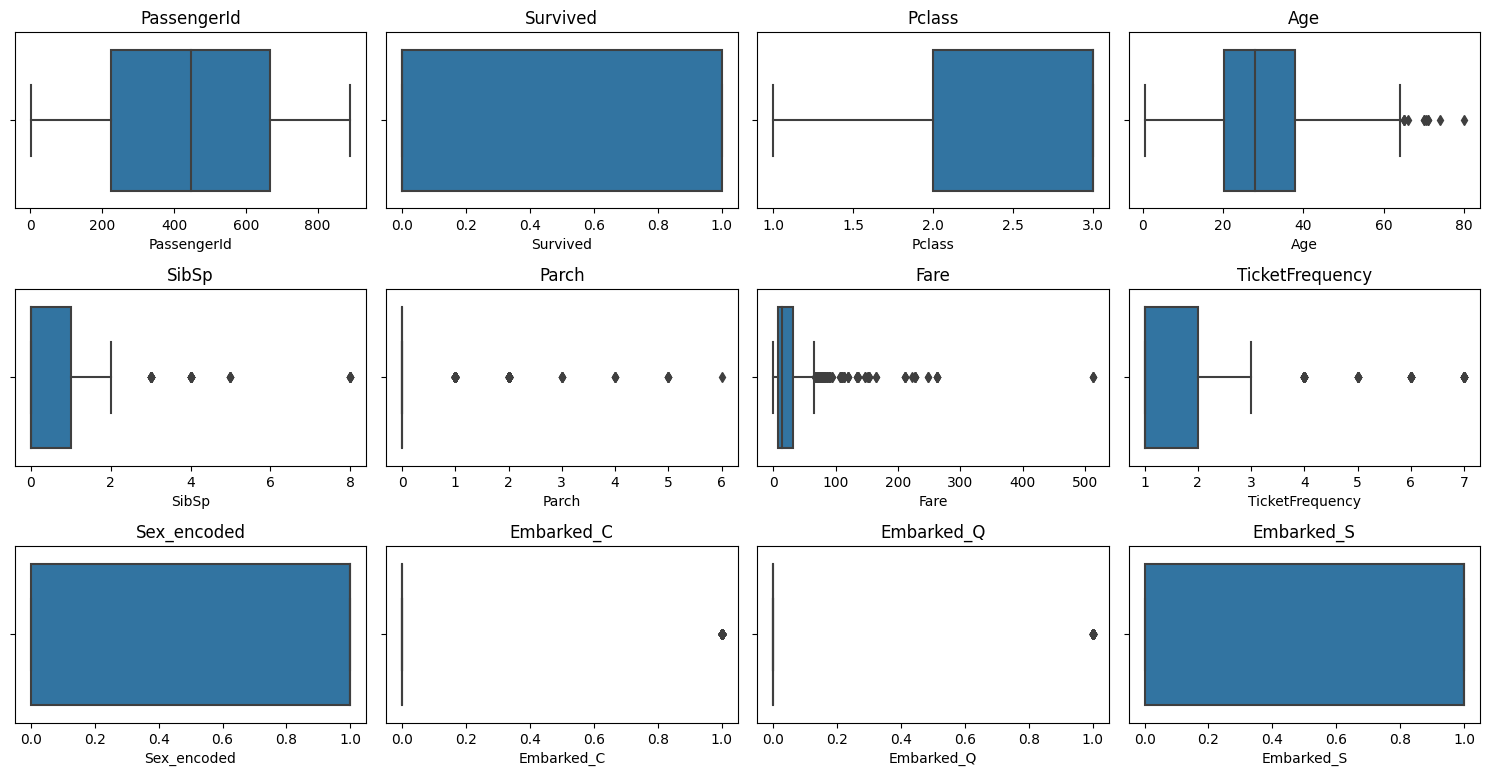

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with subplots for each feature
plt.figure(figsize=(15, 10))
for i, column in enumerate(df_train.columns):
    if df_train[column].dtype in ['int64', 'float64']:  # Select numerical columns
        plt.subplot(4, 4, i + 1) 
        sns.boxplot(x=df_train[column])
        plt.title(column)

plt.tight_layout()
plt.show()


## Exploratory Data Analysis (EDA)

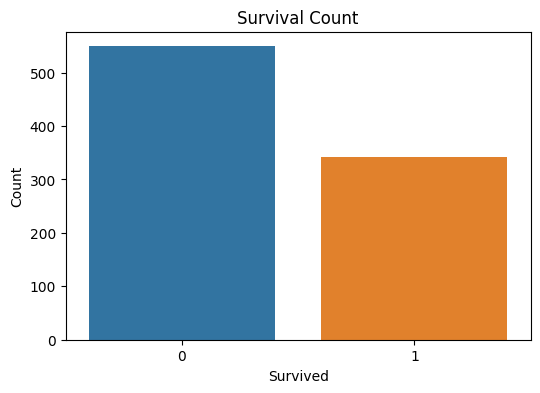

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(data=df_train, x='Survived')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.title('Survival Count')
plt.show()


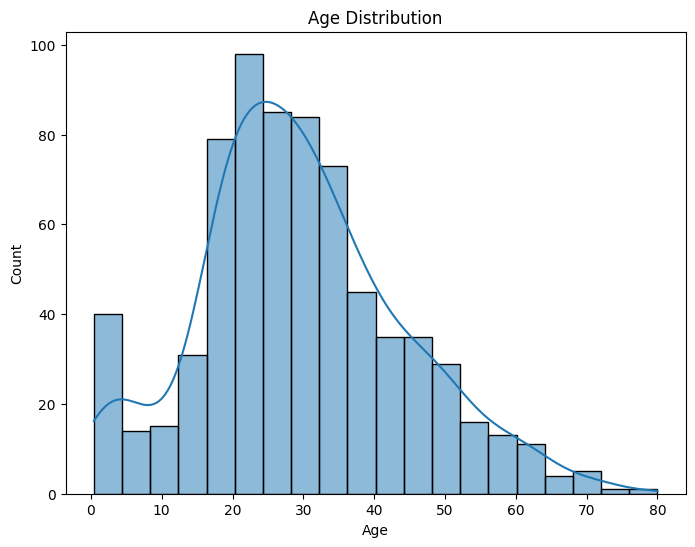

In [16]:
#before fill NaN with mean
plt.figure(figsize=(8, 6))
sns.histplot(data=df_train, x='Age', bins=20, kde=True)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()


In [17]:
df_train = fill_nan_with_mean(df_train)
X_test = fill_nan_with_mean(X_test)

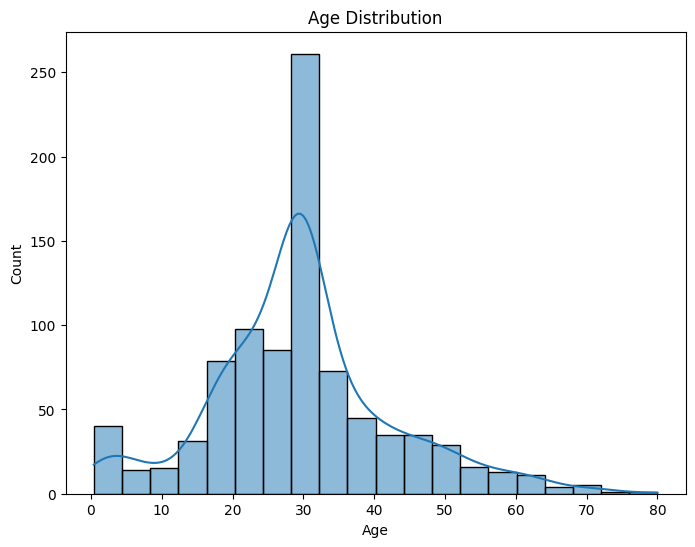

In [18]:
#after fill Nan with mean
plt.figure(figsize=(8, 6))
sns.histplot(data=df_train, x='Age', bins=20, kde=True)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()


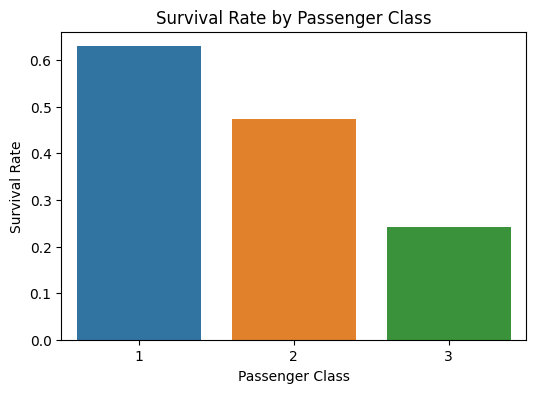

In [19]:
plt.figure(figsize=(6, 4))
sns.barplot(data=df_train, x='Pclass', y='Survived', errorbar=None)
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.title('Survival Rate by Passenger Class')
plt.show()


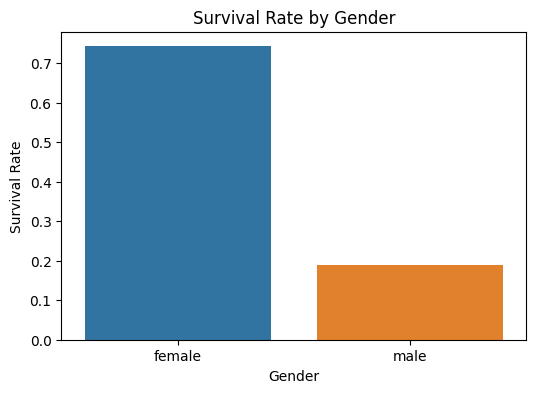

In [20]:
plt.figure(figsize=(6, 4))
sns.barplot(data=df_train, x='Sex_encoded', y='Survived', errorbar=None)
plt.xlabel('Gender')
plt.ylabel('Survival Rate')
plt.title('Survival Rate by Gender')
plt.xticks([0, 1], ['female', 'male'])
plt.show()


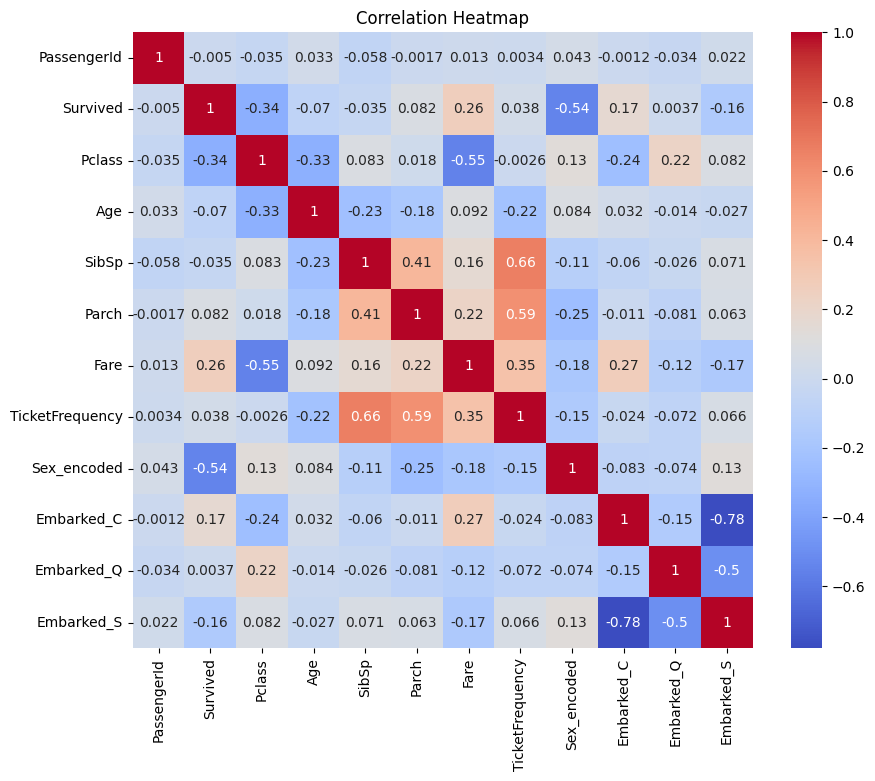

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

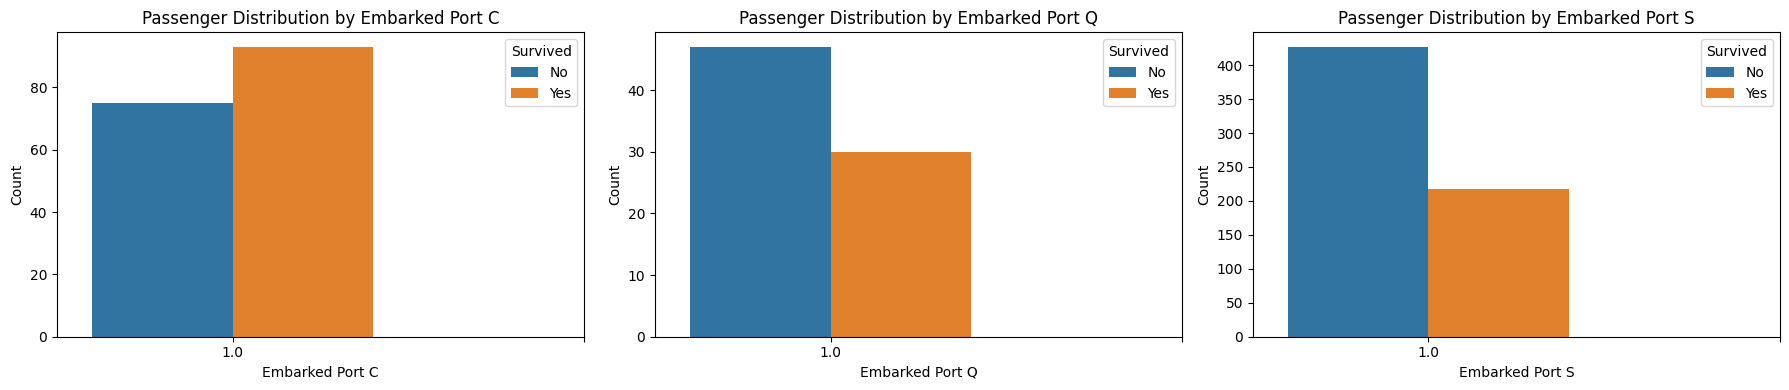

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with subplots for each port
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot for Port C
sns.countplot(data=df_train[df_train['Embarked_C'] == 1.0], x='Embarked_C', hue='Survived', ax=axes[0])
axes[0].set_xlabel('Embarked Port C')
axes[0].set_ylabel('Count')
axes[0].set_title('Passenger Distribution by Embarked Port C')

# Plot for Port Q
sns.countplot(data=df_train[df_train['Embarked_Q'] == 1.0], x='Embarked_Q', hue='Survived', ax=axes[1])
axes[1].set_xlabel('Embarked Port Q')
axes[1].set_ylabel('Count')
axes[1].set_title('Passenger Distribution by Embarked Port Q')

# Plot for Port S
sns.countplot(data=df_train[df_train['Embarked_S'] == 1.0], x='Embarked_S', hue='Survived', ax=axes[2])
axes[2].set_xlabel('Embarked Port S')
axes[2].set_ylabel('Count')
axes[2].set_title('Passenger Distribution by Embarked Port S')

# Customize the legend for all subplots
for ax in axes:
    ax.legend(title='Survived', labels=['No', 'Yes'], loc='upper right')
    ax.set_xticks([0, 1])

# Adjust subplot layout
plt.tight_layout()
plt.show()


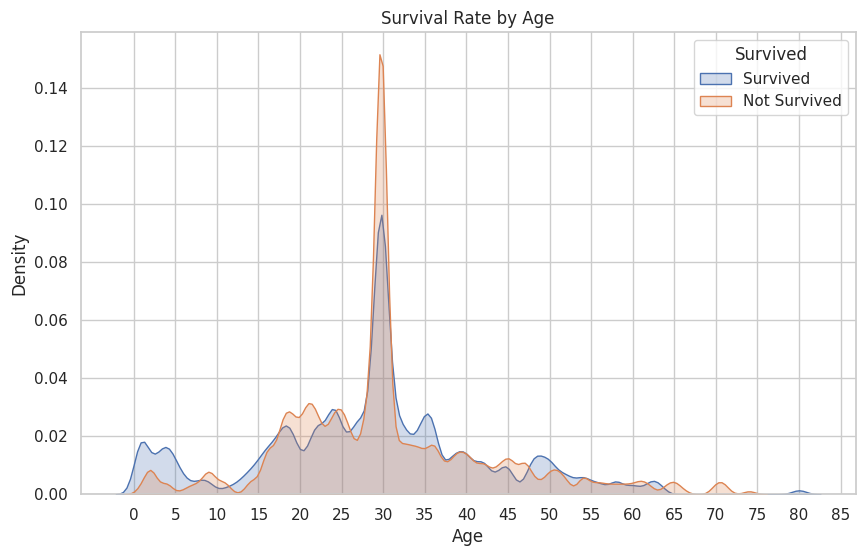

In [23]:
# Set the style of the plot
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# KDE plot for age of survivors
sns.kdeplot(df_train[df_train['Survived'] == 1]['Age'], label='Survived', fill=True, bw_adjust=0.2)

# KDE plot for age of non-survivors
sns.kdeplot(df_train[df_train['Survived'] == 0]['Age'], label='Not Survived', fill=True, bw_adjust=0.2)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Survival Rate by Age')

# Specify the number of desired x-axis ticks and their positions
x_ticks = range(0, 90, 5)  # Adjust the range and step size as needed

# Set the x-axis ticks
plt.xticks(x_ticks)

# Show a legend
plt.legend(title='Survived', labels=['Survived', 'Not Survived'])

# Show the plot
plt.show()


# Feature Engineering

In [24]:
def create_family_size_feature(df):
    """
    Create a new 'FamilySize' feature by combining 'SibSp' and 'Parch'.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing 'SibSp' and 'Parch' columns.

    Returns:
    pandas.DataFrame: The DataFrame with the 'FamilySize' feature added.
    """
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1  # Adding 1 for the passenger themselves
    return df


In [25]:
df_train = create_family_size_feature(df_train)
X_test = create_family_size_feature(X_test)

In [26]:
df_train

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,TicketFrequency,Sex_encoded,Embarked_C,Embarked_Q,Embarked_S,FamilySize
0,1,0,3,22.000000,1,0,7.2500,1,1,0.0,0.0,1.0,2
1,2,1,1,38.000000,1,0,71.2833,1,0,1.0,0.0,0.0,2
2,3,1,3,26.000000,0,0,7.9250,1,0,0.0,0.0,1.0,1
3,4,1,1,35.000000,1,0,53.1000,2,0,0.0,0.0,1.0,2
4,5,0,3,35.000000,0,0,8.0500,1,1,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,1,1,0.0,0.0,1.0,1
887,888,1,1,19.000000,0,0,30.0000,1,0,0.0,0.0,1.0,1
888,889,0,3,29.699118,1,2,23.4500,2,0,0.0,0.0,1.0,4
889,890,1,1,26.000000,0,0,30.0000,1,1,1.0,0.0,0.0,1


In [27]:
X_test

,PassengerId,Pclass,Age,SibSp,Parch,Fare,TicketFrequency,Sex_encoded,Embarked_C,Embarked_Q,Embarked_S,FamilySize
0,892,3,34.50000,0,0,7.8292,1,1,0.0,1.0,0.0,1
1,893,3,47.00000,1,0,7.0000,1,0,0.0,0.0,1.0,2
2,894,2,62.00000,0,0,9.6875,1,1,0.0,1.0,0.0,1
3,895,3,27.00000,0,0,8.6625,1,1,0.0,0.0,1.0,1
4,896,3,22.00000,1,1,12.2875,1,0,0.0,0.0,1.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,30.27259,0,0,8.0500,1,1,0.0,0.0,1.0,1
414,1306,1,39.00000,0,0,108.9000,1,0,1.0,0.0,0.0,1
415,1307,3,38.50000,0,0,7.2500,1,1,0.0,0.0,1.0,1
416,1308,3,30.27259,0,0,8.0500,1,1,0.0,0.0,1.0,1


# Modeling and Evaluation

In [28]:
from sklearn.model_selection import train_test_split

X = df_train.drop('Survived', axis=1)
y = df_train['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

def evaluate_classification_algorithms(X_train, y_train, X_val, y_val, algorithms):
    """
    Evaluate multiple classification algorithms on a validation set and return the results.

    Parameters:
    X_train (pandas.DataFrame): Training features.
    y_train (pandas.Series): Training target.
    X_val (pandas.DataFrame): Validation features.
    y_val (pandas.Series): Validation target.
    algorithms (list): List of classifier objects to evaluate.

    Returns:
    dict: A dictionary containing the evaluation results for each algorithm.
    """
    results = {}

    for clf in algorithms:
        clf_name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        report = classification_report(y_val, y_pred)
        results[clf_name] = {'Accuracy': accuracy, 'ClassificationReport': report}

    return results

# List of classification algorithms to evaluate
algorithms_to_evaluate = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    KNeighborsClassifier(),
    GaussianNB()
]

# Example usage:
# Assuming you have X_train, y_train, X_val, and y_val from your dataset

# Evaluate the algorithms on the validation set
evaluation_results = evaluate_classification_algorithms(X_train, y_train, X_val, y_val, algorithms_to_evaluate)

# Print the results for each algorithm
for clf_name, results in evaluation_results.items():
    print(f"{clf_name} Results:")
    print(f"Accuracy: {results['Accuracy']}")
    print(f"Classification Report:\n{results['ClassificationReport']}\n")


DecisionTreeClassifier Results:
Accuracy: 0.7374301675977654
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.78       105
           1       0.68      0.68      0.68        74

    accuracy                           0.74       179
   macro avg       0.73      0.73      0.73       179
weighted avg       0.74      0.74      0.74       179


RandomForestClassifier Results:
Accuracy: 0.8044692737430168
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.70      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179


SVC Results:
Accuracy: 0.5977653631284916
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.98      0.74       105
  

# tuning

In [39]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import optuna

def tune_and_evaluate_classification_algorithms(X_train, y_train, X_val, y_val, algorithms):
    """
    Tune and evaluate multiple classification algorithms on a validation set and return the results.

    Parameters:
    X_train (pandas.DataFrame): Training features.
    y_train (pandas.Series): Training target.
    X_val (pandas.DataFrame): Validation features.
    y_val (pandas.Series): Validation target.
    algorithms (list): List of classifier objects to evaluate and tune.

    Returns:
    dict: A dictionary containing the evaluation results for each algorithm.
    """
    results = {}

    for clf in algorithms:
        clf_name = clf.__class__.__name__

        # Define an Optuna objective function for hyperparameter tuning
        def objective(trial):
            # Define hyperparameters and search spaces for each classifier
            if isinstance(clf, DecisionTreeClassifier):
                criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
                max_depth = trial.suggest_int('max_depth', 1, 32)
                min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
                min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)
                clf_tuned = DecisionTreeClassifier(
                    criterion=criterion,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    random_state=42
                )
            elif isinstance(clf, RandomForestClassifier):
                n_estimators = trial.suggest_int('n_estimators', 10, 200)
                max_depth = trial.suggest_int('max_depth', 1, 32)
                min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
                min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)
                clf_tuned = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    random_state=42
                )
            # Add conditions for other classifiers here

            clf_tuned.fit(X_train, y_train)
            y_pred = clf_tuned.predict(X_val)
            accuracy = accuracy_score(y_val, y_pred)
            return -accuracy  # Optuna minimizes, so we use negative accuracy as the objective

        # Create an Optuna study and run optimization
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=100, timeout=600)  # Adjust n_trials and timeout as needed

        # Get the best hyperparameters
        best_params = study.best_params

        # Create a classifier with the best hyperparameters
        clf_tuned = clf.set_params(**best_params)

        # Fit the tuned classifier on the training data
        clf_tuned.fit(X_train, y_train)

        # Evaluate the tuned classifier on the validation data
        y_pred = clf_tuned.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        report = classification_report(y_val, y_pred)

        results[clf_name] = {'BestHyperparameters': best_params, 'Accuracy': accuracy, 'ClassificationReport': report}

    return results

# List of classification algorithms to evaluate and tune
algorithms_to_tune_and_evaluate = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
]

# Example usage:
# Assuming you have X_train, y_train, X_val, and y_val from your dataset

# Tune and evaluate the algorithms on the validation set
tuned_evaluation_results = tune_and_evaluate_classification_algorithms(X_train, y_train, X_val, y_val, algorithms_to_tune_and_evaluate)

# Print the results for each algorithm
for clf_name, results in tuned_evaluation_results.items():
    print(f"{clf_name} Results:")
    print(f"Best Hyperparameters: {results['BestHyperparameters']}")
    print(f"Accuracy: {results['Accuracy']}")
    print(f"Classification Report:\n{results['ClassificationReport']}\n")


[I 2023-09-24 12:17:52,408] A new study created in memory with name: no-name-33ab590e-dbba-4f7f-aea8-0de51d59c695
[I 2023-09-24 12:17:52,421] Trial 0 finished with value: -0.6927374301675978 and parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 0.6312078036533999, 'min_samples_leaf': 0.478217167778631}. Best is trial 0 with value: -0.6927374301675978.
[I 2023-09-24 12:17:52,432] Trial 1 finished with value: -0.6759776536312849 and parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 0.490187055169774, 'min_samples_leaf': 0.3949344802698468}. Best is trial 0 with value: -0.6927374301675978.
[I 2023-09-24 12:17:52,443] Trial 2 finished with value: -0.7821229050279329 and parameters: {'criterion': 'gini', 'max_depth': 19, 'min_samples_split': 0.8154290496605469, 'min_samples_leaf': 0.313075460688935}. Best is trial 2 with value: -0.7821229050279329.
[I 2023-09-24 12:17:52,453] Trial 3 finished with value: -0.7821229050279329 and parameters: {

DecisionTreeClassifier Results:
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 19, 'min_samples_split': 0.8154290496605469, 'min_samples_leaf': 0.313075460688935}
Accuracy: 0.7821229050279329
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       105
           1       0.75      0.70      0.73        74

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179


RandomForestClassifier Results:
Best Hyperparameters: {'n_estimators': 80, 'max_depth': 14, 'min_samples_split': 0.27009992367508906, 'min_samples_leaf': 0.10264205197903553}
Accuracy: 0.7430167597765364
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.87      0.80       105
           1       0.75      0.57      0.65        74

    accuracy                           0.74       179
  

In [30]:
model = RandomForestClassifier()
model.fit(X,y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)

In [41]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import optuna

def tune_and_evaluate_classification_algorithms_kfold(X, y, algorithms, cv=5, n_trials=50):
    """
    Tune and evaluate multiple classification algorithms using K-fold cross-validation and return the results.

    Parameters:
    X (pandas.DataFrame): Features.
    y (pandas.Series): Target.
    algorithms (list): List of classifier objects to evaluate and tune.
    cv (int): Number of folds for cross-validation (default is 5).
    n_trials (int): Number of Optuna trials for hyperparameter tuning (default is 50).

    Returns:
    dict: A dictionary containing the evaluation results for each algorithm.
    """
    results = {}

    for clf in algorithms:
        clf_name = clf.__class__.__name__

        # Define an Optuna objective function for hyperparameter tuning
        def objective(trial):
            # Define hyperparameters and search spaces for each classifier
            if isinstance(clf, DecisionTreeClassifier):
                criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
                max_depth = trial.suggest_int('max_depth', 1, 32)
                min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
                min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)
                clf_tuned = DecisionTreeClassifier(
                    criterion=criterion,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    random_state=42
                )
            elif isinstance(clf, RandomForestClassifier):
                n_estimators = trial.suggest_int('n_estimators', 10, 200)
                max_depth = trial.suggest_int('max_depth', 1, 32)
                min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
                min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)
                clf_tuned = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    random_state=42
                )
            # Add conditions for other classifiers here

            kf = KFold(n_splits=cv, shuffle=True, random_state=42)
            accuracy_scores = []

            for train_idx, val_idx in kf.split(X):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

                clf_tuned.fit(X_train, y_train)
                y_pred = clf_tuned.predict(X_val)

                accuracy_scores.append(accuracy_score(y_val, y_pred))

            # Calculate mean accuracy across folds
            mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
            return -mean_accuracy  # Optuna minimizes, so we use negative accuracy as the objective

        # Create an Optuna study and run optimization
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials, timeout=None)  # Adjust n_trials and timeout as needed

        # Get the best hyperparameters
        best_params = study.best_params

        # Create a classifier with the best hyperparameters
        clf_tuned = clf.set_params(**best_params)

        # Fit the tuned classifier on the entire dataset
        clf_tuned.fit(X, y)

        # Evaluate the tuned classifier on the entire dataset
        y_pred = clf_tuned.predict(X)
        accuracy = accuracy_score(y, y_pred)
        report = classification_report(y, y_pred)

        results[clf_name] = {'BestHyperparameters': best_params, 'Accuracy': accuracy, 'ClassificationReport': report}

    return results

# List of classification algorithms to evaluate and tune
algorithms_to_tune_and_evaluate = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
]

# Example usage:
# Assuming you have X and y from your dataset

# Tune and evaluate the algorithms using K-fold cross-validation
tuned_evaluation_results = tune_and_evaluate_classification_algorithms_kfold(X, y, algorithms_to_tune_and_evaluate, cv=5, n_trials=100)

# Print the results for each algorithm
for clf_name, results in tuned_evaluation_results.items():
    print(f"{clf_name} Results:")
    print(f"Best Hyperparameters: {results['BestHyperparameters']}")
    print(f"Accuracy: {results['Accuracy']}")
    print(f"Classification Report:\n{results['ClassificationReport']}\n")


[I 2023-09-24 12:22:08,398] A new study created in memory with name: no-name-df17c9f5-4b35-4eca-a53b-7d1e76eabca1
[I 2023-09-24 12:22:08,443] Trial 0 finished with value: -0.786761659657272 and parameters: {'criterion': 'gini', 'max_depth': 24, 'min_samples_split': 0.6396922331589109, 'min_samples_leaf': 0.27317241576145224}. Best is trial 0 with value: -0.786761659657272.
[I 2023-09-24 12:22:08,486] Trial 1 finished with value: -0.786761659657272 and parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 0.30584965596883407, 'min_samples_leaf': 0.1809837377872756}. Best is trial 0 with value: -0.786761659657272.
[I 2023-09-24 12:22:08,529] Trial 2 finished with value: -0.786761659657272 and parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 0.8892979557366334, 'min_samples_leaf': 0.11613865304055171}. Best is trial 0 with value: -0.786761659657272.
[I 2023-09-24 12:22:08,571] Trial 3 finished with value: -0.786761659657272 and parameters: {'crit

DecisionTreeClassifier Results:
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 24, 'min_samples_split': 0.6396922331589109, 'min_samples_leaf': 0.27317241576145224}
Accuracy: 0.7867564534231201
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       549
           1       0.74      0.68      0.71       342

    accuracy                           0.79       891
   macro avg       0.78      0.77      0.77       891
weighted avg       0.78      0.79      0.78       891


RandomForestClassifier Results:
Best Hyperparameters: {'n_estimators': 46, 'max_depth': 20, 'min_samples_split': 0.3186652262497193, 'min_samples_leaf': 0.14853376550306038}
Accuracy: 0.7564534231200898
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.97      0.83       549
           1       0.89      0.42      0.57       342

    accuracy                           0.76       891
 